In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sympy import Symbol, symbols, solve, diff
np.set_printoptions(threshold=np.inf)

import openfermion as of
from openfermion.linalg import get_sparse_operator, get_ground_state
from openfermion.transforms import get_quadratic_hamiltonian
from openfermion.circuits import gaussian_state_preparation_circuit, jw_get_gaussian_state, prepare_gaussian_state
      
from mindquantum import *
from mindquantum.core.operators import QubitOperator
from mindquantum.core.circuit import decompose_single_term_time_evolution


In [4]:
def inital_circuits(occupied, circuit_description):
    
    circuit = Circuit()
    for i in range(occupied):
        circuit += X.on(i)

    circuit.barrier()

    for i in circuit_description:
        if len(i) == 1:
            q0 = i[0][0]
            q1 = i[0][1]
            theta = i[0][2]
            circuit += givens_iswap([q0, q1], theta)
            circuit.barrier()
        if len(i) != 1:
            for j in i:
                q0 = j[0]
                q1 = j[1]
                theta = j[2]
                circuit += givens_iswap([q0, q1], theta)
                circuit.barrier()
                
    return circuit

def lamt(t, T):

    return np.sin((np.pi/2)*np.sin(np.pi*t/(2*T))**2)**2

def deri_lamt2(t, T):
    
    w = np.pi/(2*T)

    return 2*w**2*np.sin(w*t)*np.cos(w*t)

def deri_lamt(t, T):
    
    return 2*np.sin(np.pi/2*(np.sin(np.pi*t/(2*T))**2))*np.cos(np.pi/2*(np.sin(np.pi*t/(2*T))**2))*\
                    (np.pi/2)*2*np.sin(np.pi*t/(2*T))*np.cos(np.pi*t/(2*T))*np.pi/(2*T)


def generate_Hamitonian():
    
    # # generate fermi hubbard model's hamitonian using openfemi pakage
    H_hopping = of.fermi_hubbard(x_dimension=6, y_dimension=1,tunneling= 1, coulomb=0, chemical_potential=0.0,\
                                 magnetic_field=0.0,periodic=True)
    
    H_coulomb = of.fermi_hubbard(x_dimension=6,y_dimension=1, tunneling=0, coulomb=1.5, chemical_potential=0.0,\
                                 magnetic_field=0.0,periodic=True)
    
    from openfermion.ops import FermionOperator


    hubbard_model = H_hopping + H_coulomb
    
    # Jordan wigner Transform
    H_hopping_qubit = of.jordan_wigner(H_hopping)
    H_coulomb_qubit = of.jordan_wigner(H_coulomb)
    
    # Transform to Mindquantum
    H_hopping_qubit = QubitOperator.from_openfermion(H_hopping_qubit)
    H_coulomb_qubit = QubitOperator.from_openfermion(H_coulomb_qubit)
    H = H_hopping_qubit + H_coulomb_qubit
    
    # Transform the hamitonian to Mindquantum 
    qubit_Hamitonian = Hamiltonian(H)  

    return H_hopping_qubit, H_coulomb_qubit, H_hopping, hubbard_model, qubit_Hamitonian


def Hooping_Hamitonian_simulation(theta):
    
    circuit = Circuit()

    for qubit_operator in H_hopping_qubit:

        circuit += decompose_single_term_time_evolution(qubit_operator, {'a': -0.5*theta})
        
    return circuit

def Fermi_hubbard_Hamitonian_simulatoin(theta):
    
    circuit = Circuit()
        
    for i, qubit_operator in enumerate(H_coulomb_qubit):

        if i!= 0:
            for j in qubit_operator.split():
                
                    for key, term in j[1].terms.items():
                        
                        if len(key) == 1:
                            circuit += decompose_single_term_time_evolution(qubit_operator, {'c':-0.375*theta})
                        else:
                            circuit += decompose_single_term_time_evolution(qubit_operator, {'d':0.375*theta})
                            
    return circuit

def CD_circuits(CD_operator, theta):
    
    coefficent_record = []
    for cd in CD_operator.split():
        # CD_term.append(cd[1])
        coefficent_record.append(cd[0].const)
    
    circuit = Circuit()
    
    for index, qubit_operator in enumerate(CD_operator):

        circuit += decompose_single_term_time_evolution(qubit_operator, {'d': coefficent_record[index].imag*theta})
                            
    return circuit

In [5]:
from collections import OrderedDict as ordict

def CD_operator_generate(CD, interaction_term):
    
    CD_term = []
    for cd in CD.split():
        for key, term in cd.terms():
            if len(key) <= interaction_term:
                print((cd))
                CD_term.append(cd[1])
    k = 0
    out = ordict()
    for cd in CD_term:
        for key, term in cd.terms.items():
            if len(key) <= interaction_term:
                #print(len(key))
                if key not in out:
                    out[key] = ordict({f"p{k}": 1})
                    k += 1
    return out, CD_term

In [6]:
# generate the hamitonian

global H_hopping_qubit
global H_coulomb_qubit

H_hopping_qubit, H_coulomb_qubit, H_hopping, hubbard_model, qubit_Hamitonian = generate_Hamitonian()
 
# check the occupied orbitals for the ground state
occupied_orbitals = [0, 1, 2, 3, 4, 5]

# the hopping hamitonian's ground state 
quadratic_hamiltonian = get_quadratic_hamiltonian(H_hopping)
circuit_description, start_orbitals = gaussian_state_preparation_circuit(quadratic_hamiltonian, 
                                                                         occupied_orbitals, 
                                                                         spin_sector=None)

# the ground energy and ground state of the Hopping hamitonian,
ground_energy, ground_state = jw_get_gaussian_state(quadratic_hamiltonian, occupied_orbitals)
ground_energy2, ground_state2 = jw_get_gaussian_state(quadratic_hamiltonian)

# the ground energy and ground state of the Fermi Hubbard model
sparse_operator = get_sparse_operator(hubbard_model)
ground_energy, ground_state = get_ground_state(sparse_operator)


print("the ground energy of hopping Hamitonian using the occuped orbitals:\n--- ", ground_energy)
print("the ground energy of hopping Hamitonian using the direct diagnal matrix: \n--- ", ground_energy2)
print("Overlap is between the two state: \n---", np.dot(ground_state2.T.conjugate(), ground_state)**2)
print("The exact ground state of Fermi-Hubbard model is:\n--- ", ground_energy)

the ground energy of hopping Hamitonian using the occuped orbitals:
---  -5.978815789177411
the ground energy of hopping Hamitonian using the direct diagnal matrix: 
---  -8.0
Overlap is between the two state: 
--- (-0.7770239885317585+0.5532076860034427j)
The exact ground state of Fermi-Hubbard model is:
---  -5.978815789177411


## Counter diabatic evolution

In [7]:
global CD_operator
CD_operator = commutator(H_hopping_qubit, H_coulomb_qubit)

H_T = H_hopping_qubit
H_P = H_hopping_qubit + H_coulomb_qubit

A1 = commutator(H_hopping_qubit, H_coulomb_qubit)

commut1 = commutator(H_T, A1).matrix().toarray()
commut2 = commutator(H_P, A1).matrix().toarray()
H_hopping_qubit_matrix = H_hopping_qubit.matrix().toarray()

In [8]:
coefficent, L = symbols('coefficent, lambdas', complex=True)

qubit = 12
fp0 = np.zeros((2**qubit, 2**qubit), dtype=object)
from tqdm import tqdm
for i in tqdm(range(2**qubit)):
    for j in range(2**qubit):
        fp0[i,j] = H_hopping_qubit_matrix[i,j] + ((1-L)*commut1[i,j] + L*commut2[i,j]) * coefficent
        
S_l = []
fp0_1 = fp0.copy()

for i in tqdm(range(2**qubit)):
    y = np.dot(fp0_1[i,:], fp0_1[:, i])
    S_l.append(y)
    
S_l = sum(S_l)

func = diff(S_l, coefficent)

print(func)
slv = solve(func, coefficent)[0] 
coefficent_expression = repr(slv)

100%|██████████| 4096/4096 [00:22<00:00, 183.76it/s]


In [11]:
Delta_t = 0.02
Expectation_adibatic = []

k = 0
T = 1
n = int(T/Delta_t)
t = np.linspace(0, T, n)
circ = Circuit()

for i in tqdm(range(0, int(n))):

    theta_1 = (1-lamt(i*Delta_t, T))*Delta_t
    theta_2 = (lamt(i*Delta_t, T))*Delta_t
    lambdas = lamt(i*Delta_t, T)

    circ += Hooping_Hamitonian_simulation(Delta_t)
    circ += Fermi_hubbard_Hamitonian_simulatoin(theta_2)
    sim = Simulator('mqvector', circ.n_qubits)
    sim.set_qs(ground_state2)
    sim.apply_circuit(circ, pr={"a":1, "b":1, "c":1, "d":1})
    result = sim.get_qs()
    expectation = sim.get_expectation(qubit_Hamitonian)
    Expectation_adibatic.append(expectation)
    k += 1

100%|██████████| 50/50 [00:15<00:00,  3.15it/s]


In [13]:
Delta_t = 0.02
Expectation_record3 = []

k = 0

T = 1
n = int(T/Delta_t)
circ = Circuit()

for i in tqdm(range(0, int(n))):

    theta_1 = (1-lamt(i*Delta_t, T))*Delta_t
    theta_2 = (lamt(i*Delta_t, T))*Delta_t
    lambdas = lamt(i*Delta_t, T)
    derivative_lambdas = deri_lamt(i*Delta_t, T)
    theta_3 = eval(coefficent_expression)*Delta_t*derivative_lambdas*1.j

    circ += Hooping_Hamitonian_simulation(Delta_t)
    circ += Fermi_hubbard_Hamitonian_simulatoin(theta_2)
    circ += CD_circuits(CD_operator,alphas_value[i] )
    # circ += CD_circuits(theta_3.imag)
    
    # print("------------------")
    sim = Simulator('mqvector', circ.n_qubits)
    sim.set_qs(ground_state2)
    sim.apply_circuit(circ, pr={"a":1, "b":1, "c":1, "d":1})
    result = sim.get_qs()
    expectation = sim.get_expectation(qubit_Hamitonian)
    fidelity = abs(np.dot(ground_state.T.conjugate(), result))**2

    #print(fidelity)
    Expectation_record3.append(expectation)
    k += 1

100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


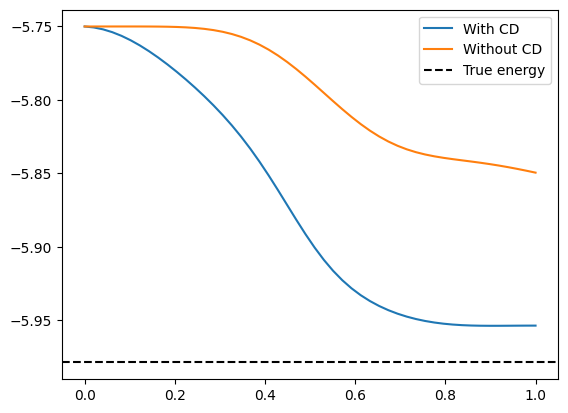

In [18]:
plt.plot(t,Expectation_record3, label='With CD')
plt.plot(t,Expectation_adibatic, label='Without CD')
plt.axhline(y=ground_energy, color="black", linestyle="--", label="True energy")
plt.legend()